In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyopenms import *

In [2]:
def experiment_iter(method, sample = None, penalty = None):
    if sample is None:
        sample = ["UWPROFL0360", "UWPROFL0361", "UWPROFL0362", "UWPROFL0363", "UWPROFL0364"]
    if penalty is None:
        penalty = ["1e5", "3e5", "1e6", "3e6", 
                   "1e7", "3e7", "1e8", "3e8", 
                   "1e9", "3e9", "1e10", "3e10",
                   "1e11", "3e11", "1e12", "3e12", 
                   "1e13", "3e13"]
        
    for s in sample:
        for p in penalty:
            yield s + "_" + method + "_" + p
            
            
def sgl_iter(l1_penalty, sample = None, l2_penalty = None):
    if sample is None:
        sample = ["UWPROFL0360", "UWPROFL0361", "UWPROFL0362", "UWPROFL0363", "UWPROFL0364"]
    if l2_penalty is None:
        l2_penalty = ["1e8", "3e8", "1e9", "3e9", "1e10", "3e10", "1e11", "3e11"]
        
    for s in sample:
        for p in l2_penalty:
            yield s + "_" + "sglasso" + "_" + p + "_" + l1_penalty   
    

def get_experiment(experiment):
    try:
        peptides = pd.read_csv("../Results/" + experiment + "_peptide_hits", 
                               header=-1, sep="\t")
        peptides.columns = ["index", "target", "peptide", "matching", "penalized", "debiased"]
        decoys = pd.read_csv("../Results/" + experiment + "_decoy_hits", 
                             header=-1, sep="\t")
        decoys.columns = ["index", "target", "peptide", "matching", "penalized"]
        return peptides, decoys
    
    except:
        peptides = pd.DataFrame(columns=["index", "target", "peptide", "matching", "penalized", "debiased"])
        decoys = pd.DataFrame(columns=["index", "target", "peptide", "matching", "penalized"])
        return peptides, decoys
    
def value_filter(data, quant):
    select = data["penalized"] > np.quantile(data["penalized"], quant)
    return data[select]

In [68]:
def matching_peaks_wa(data):
    data = data.copy()
    data["matching"] *= data["penalized"]
    sums = data.groupby("peptide")["matching"].sum()
    return sums / data.groupby("peptide")["penalized"].sum()

def fsr_cutoff(peptides, decoys, cutoff=0.01):
    pep_counts = matching_peaks_wa(peptides)
    decoy_counts = matching_peaks_wa(decoys)
    
    def optim(thresh):
        true_hits = np.sum(pep_counts >= thresh)
        false_hits = np.sum(decoy_counts >= thresh)
        fdr = false_hits/(true_hits + false_hits)
        return (cutoff - fdr)**2
    
    top_thresholds = np.random.uniform(0, 10, size = 3)
    for i in np.arange(-3, 2)[::-1]:
        sd = np.power(10., i)
        suggestions = sd * np.random.randn(10, 3) + top_thresholds
        scores = np.array([optim(t) for t in suggestions.flatten()])
        best_args = np.argsort(scores)[:3]
        top_thresholds = suggestions.flatten()[best_args]
    
    best_thresh = np.min(top_thresholds)
    return pep_counts[pep_counts >= best_thresh], decoy_counts[decoy_counts >= best_thresh], best_thresh

In [69]:
def gather_group_map():
    peptides, _ = get_experiment("UWPROFL0362_lasso_1e6")
    targets = np.unique(peptides.target)
    labels = np.array([i % 2 for i in range(len(targets))])
    group_map = {t : l for t,l in zip(targets, labels)}
    return group_map

In [20]:
group_map = gather_group_map()

In [21]:
def gather_agreement(gen):
    agreement = []
    for exp in gen:
        peptides, decoys = get_experiment(exp)
        if peptides.shape[0] == 0 or decoys.shape[0] == 0:
            break
        peptides, decoys = value_filter(peptides, .5), value_filter(decoys, .5)
        peptides["group"] = [group_map[t] for t in peptides.target]
        decoys["group"] = [group_map[t] for t in decoys.target]
        
        selected_peptides, selected_decoys, thresh = fsr_cutoff(peptides[peptides.group == 0],
                                                                decoys[decoys.group == 0],
                                                                cutoff=0.01)
        group_1_counts = matching_peaks_wa(peptides[peptides.group == 1])
        group_1_select = group_1_counts > thresh
        selected_peptides_1 = group_1_counts[group_1_select]
        
        peptide_union = np.union1d(selected_peptides.index.values, selected_peptides_1.index.values)
        peptide_intersect = np.intersect1d(selected_peptides.index.values, selected_peptides_1.index.values)
        agreement.append(len(peptide_intersect)/len(peptide_union))
    return agreement

In [22]:
lasso_agreement = gather_agreement(experiment_iter("lasso", sample=["UWPROFL0362"]))
glasso_agreement = gather_agreement(experiment_iter("glasso", sample=["UWPROFL0362"]))
sglasso_agreement = []
for p in ["1e7", "1e8", "1e9", "1e10", "1e11"]:
    sglasso_agreement.append(gather_agreement(
        sgl_iter(p, sample=["UWPROFL0362"]))
                            )

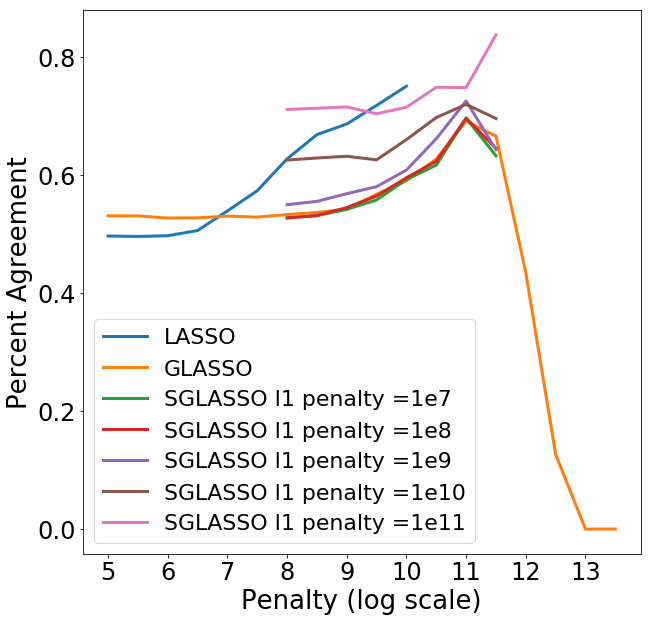

In [65]:
plt.figure(figsize=(10, 10))
plt.plot(np.arange(len(lasso_agreement))/2 + 5, lasso_agreement, label="LASSO", lw=3)
plt.plot(np.arange(len(glasso_agreement))/2 + 5, glasso_agreement, label="GLASSO", lw=3)
for ind in range(len(sglasso_agreement)):
    plt.plot(np.arange(len(sglasso_agreement[ind]))/2 + 8, sglasso_agreement[ind], lw = 3,
             label = "SGLASSO l1 penalty =" + ["1e7", "1e8", "1e9", "1e10", "1e11"][ind])

plt.xlabel("Penalty (log scale)", size=26)
plt.ylabel("Percent Agreement", size=26)
plt.tick_params(labelsize=24)
plt.legend(loc=3, prop={'size': 22})
plt.xticks(np.arange(9) + 5)
plt.show()

In [43]:
def gather_total_selection(gen):
    counts = []
    for exp in gen:
        peptides, decoys = get_experiment(exp)
        if peptides.shape[0] == 0 or decoys.shape[0] == 0:
            break
        peptides, decoys = value_filter(peptides, .5), value_filter(decoys, .5)
        peptides["group"] = [group_map[t] for t in peptides.target]
        decoys["group"] = [group_map[t] for t in decoys.target]
        
        selected_peptides, selected_decoys, thresh = fsr_cutoff(peptides[peptides.group == 0],
                                                                decoys[decoys.group == 0],
                                                                cutoff=0.01)
        group_1_counts = matching_peaks_wa(peptides[peptides.group == 1])
        group_1_select = group_1_counts > thresh
        selected_peptides_1 = group_1_counts[group_1_select]
        
        peptide_union = np.union1d(selected_peptides.index.values, selected_peptides_1.index.values)
        counts.append(len(peptide_union))
    return counts

In [44]:
lasso_counts = gather_total_selection(experiment_iter("lasso", sample=["UWPROFL0362"]))
glasso_counts = gather_total_selection(experiment_iter("glasso", sample=["UWPROFL0362"]))
sglasso_counts = []
for p in ["1e7", "1e8", "1e9", "1e10", "1e11"]:
    sglasso_counts.append(gather_total_selection(
        sgl_iter(p, sample=["UWPROFL0362"]))
                            )

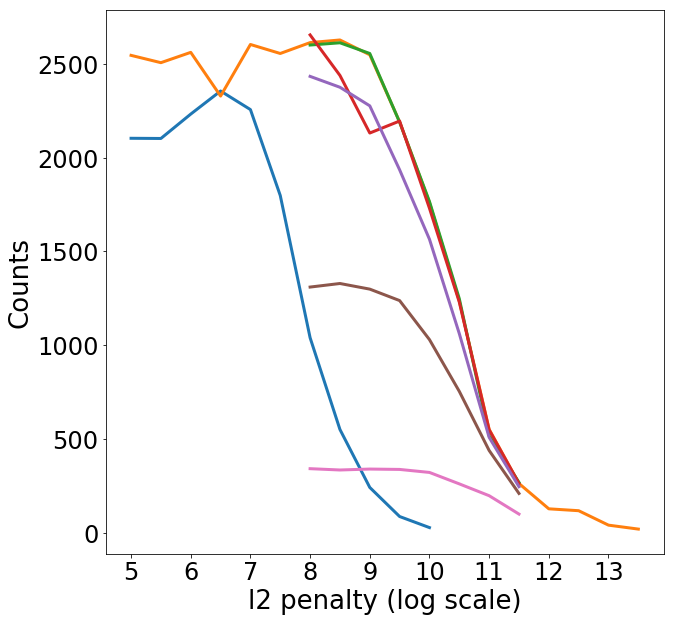

In [47]:
plt.figure(figsize=(10, 10))
plt.plot(np.arange(len(lasso_counts))/2 + 5, lasso_counts, label="LASSO", lw=3)
plt.plot(np.arange(len(glasso_counts))/2 + 5, glasso_counts, label="GLASSO", lw=3)
for ind in range(len(sglasso_counts)):
    plt.plot(np.arange(len(sglasso_counts[ind]))/2 + 8, sglasso_counts[ind], lw = 3,
             label = "SGLASSO l1 penalty =" + ["1e7", "1e8", "1e9", "1e10", "1e11"][ind])

plt.xlabel("Penalty (log scale)", size=26)
plt.ylabel("Counts", size=26)
plt.tick_params(labelsize=24)
plt.xticks(np.arange(9) + 5)
plt.show()

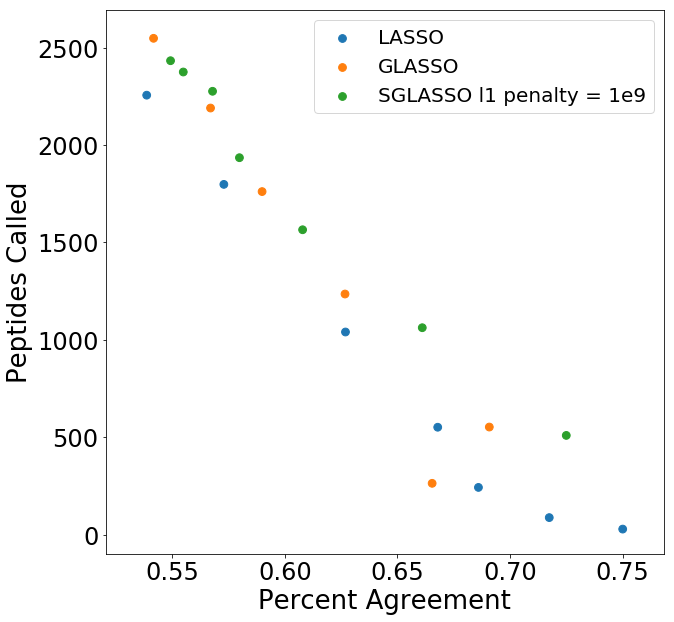

In [64]:
plt.figure(figsize=(10, 10))
plt.scatter(lasso_agreement[4:], lasso_counts[4:], label="LASSO", s = [60]*len(lasso_agreement[4:]))
plt.scatter(glasso_agreement[8:-4], glasso_counts[8:-4], label="GLASSO", s = [60]*len(glasso_agreement[8:-4]))
plt.scatter(sglasso_agreement[2][:-1], sglasso_counts[2][:-1], label="SGLASSO l1 penalty = 1e9", 
            s = [60]*len(sglasso_agreement[2][:-1]))

plt.xlabel("Percent Agreement", size=26)
plt.ylabel("Peptides Called", size=26)
plt.tick_params(labelsize=24)
plt.legend(loc=1, prop={'size': 20})
plt.show()

In [71]:
["1e5", "3e5", "1e6", "3e6", 
                   "1e7", "3e7", "1e8", "3e8", 
                   "1e9", "3e9", "1e10", "3e10",
                   "1e11", "3e11", "1e12", "3e12", 
                   "1e13", "3e13"][8:-4]

['1e9', '3e9', '1e10', '3e10', '1e11', '3e11']